In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.PASCAL_2007)

In [3]:
imgs, lbl_bbox = get_annotations(path/'train.json')
imgs[0], lbl_bbox[0]

('000012.jpg', ([[155, 96, 351, 270]], ['car']))

In [4]:
# We want to quickly look up a corresponding image to its label.
# We will use a dictionary, and check it
img2bbox = dict(zip(imgs, lbl_bbox))

# check
first = {k: img2bbox[k] for k in list(img2bbox[:1])}
print(first)

TypeError: unhashable type: 'slice'

In [5]:
# get the data and their bounding box label
getters = [lambda x: path/'train'/x, lambda x: img2bbox[x][0], lambda x: img2bbox[x][1]]

In [24]:
# data transforms
item_tfms = [Resize(128, method = 'pad')]

# data bunch transforms
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [7]:
# we want 'images' to come back, but not entire folder
def get_train_imgs(noop):
    return imgs

In [8]:
# make the datablock, adjust n_inp, expect two outputs
pascal  = DataBlock(blocks = (ImageBlock, BBoxBlock, BBoxLblBlock),
                    splitter = RandomSplitter(),
                    get_items = get_train_imgs,
                    getters = getters,
                    item_tfms = item_tfms,
                    batch_tfms = batch_tfms,
                    n_inp = 1)

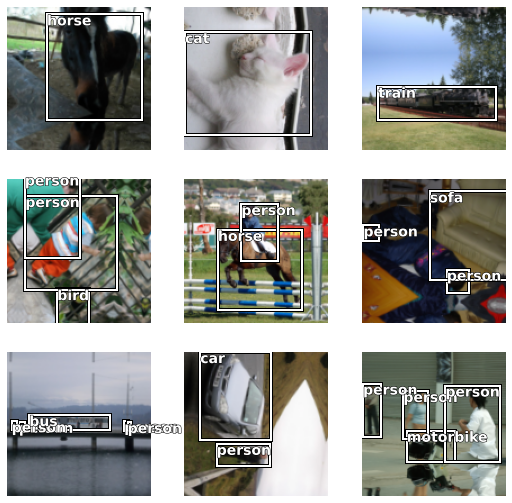

In [9]:
# data loaders of fastai
dls = pascal.dataloaders(path/'train')
dls.c = 20 # ???
dls.show_batch()

In [10]:
# use the model
from wwf.vision.object_detection import *

In [11]:
encoder = create_body(resnet34, pretrained = True)

# we get the encoder, and call it 'RetinaNet'
# we will pass in the encoder:
#     the number of classes;
#     what we want our final bias to be, on the last convolutional layer (how we initialize our model)

In [12]:
arch = RetinaNet(encoder, get_c(dls), final_bias = -4) # meaning of c?, why final_bias?

In [13]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=248, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

In [14]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [15]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [16]:
arch.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [17]:
import torch
import torch.nn as nn

In [18]:
# building the loss function
ratios = [1/2, 1, 2]
scales = [1, 2 ** (-1 / 3), 2 ** (-2 / 3)]

# make loss function, which is RetinaFocalLoss
crit = RetinaNetFocalLoss(scales = scales, ratios = ratios)

In [25]:
# for fixing the bug: no implementation found for 'torch.nn.functional.smooth_l1_loss' on types that implement __torch_function__: [<class 'fastai.torch_core.TensorImage'>, <class 'fastai.vision.core.TensorBBox'>] 
class cast_to_tensor(Module):
    def forward(self, x): 
        return cast(x, Tensor)

In [26]:
# build the learner
# firstly, freeze the encoder and keep everything everything else unfrozen to start
def _retinanet_split(m): 
    return L(m.encoder,
             nn.Sequential(m.c5top6,
                           m.p6top7,
                           m.merges,
                           m.smoothers,
                           m.classifier,
                           m.box_regressor,
                           cast_to_tensor(),
                          )).map(params)

In [27]:
learn = Learner(dls, arch, loss_func = crit, splitter = _retinanet_split, metrics = metrics)

In [29]:
learn.freeze()
learn.fit_one_cycle(10, slice(1e-5, 1e-4))
# learn.fine_tune(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,wwf.vision.object_detection.metrics,time


TypeError: no implementation found for 'torch.nn.functional.smooth_l1_loss' on types that implement __torch_function__: [<class 'fastai.torch_core.TensorImage'>, <class 'fastai.vision.core.TensorBBox'>]

In [ ]:
# because wwf can not show the results for now,
# the author said that it might be possible to use 'ice vision'
# https://github.com/airctic/icevision
from icevision.all import *
# ...